In [1]:
from pennylane import numpy as np
import torch
from torch import nn
import pennylane as qml
import matplotlib.pyplot as plt

import functools

# reproducibility
torch.manual_seed(0)
np.random.seed(0)

In [2]:
def deterministic(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        torch.manual_seed(0)
        np.random.seed(0)
        value = func(*args, **kwargs)
        return value
    return wrapper

## Basic circuit

(<Figure size 800x200 with 1 Axes>, <Axes: >)

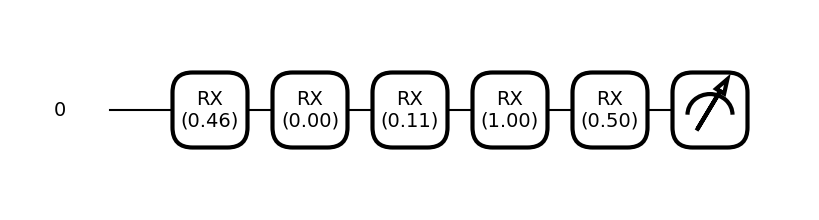

In [6]:
n_qubits = 1
n_depth = 2
n_layers = 1
in_dim = n_qubits * n_depth
dev = qml.device("lightning.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def circuit(inputs, w):
    qml.BasicEntanglerLayers(w[0], wires=range(n_qubits), rotation=qml.RX)
    
    for i in range(n_depth):
        qml.AngleEmbedding(features=inputs[i*n_qubits : (i+1)*n_qubits],
                           wires=range(n_qubits),
                           rotation="X")
        qml.BasicEntanglerLayers(w[i+1],
                                 wires=range(n_qubits),
                                 rotation=qml.RX)
        
    return [qml.expval(qml.PauliZ(k)) for k in range(1)]

weight_shapes = {"w": (n_depth+1, n_layers, n_qubits)}

qml.draw_mpl(circuit, decimals=2, expansion_strategy='device')(inputs=torch.arange(n_qubits*n_depth, dtype=float),
                                                               w=torch.rand(weight_shapes["w"]))

## Strongly entangling circuit

(<Figure size 3200x500 with 1 Axes>, <Axes: >)

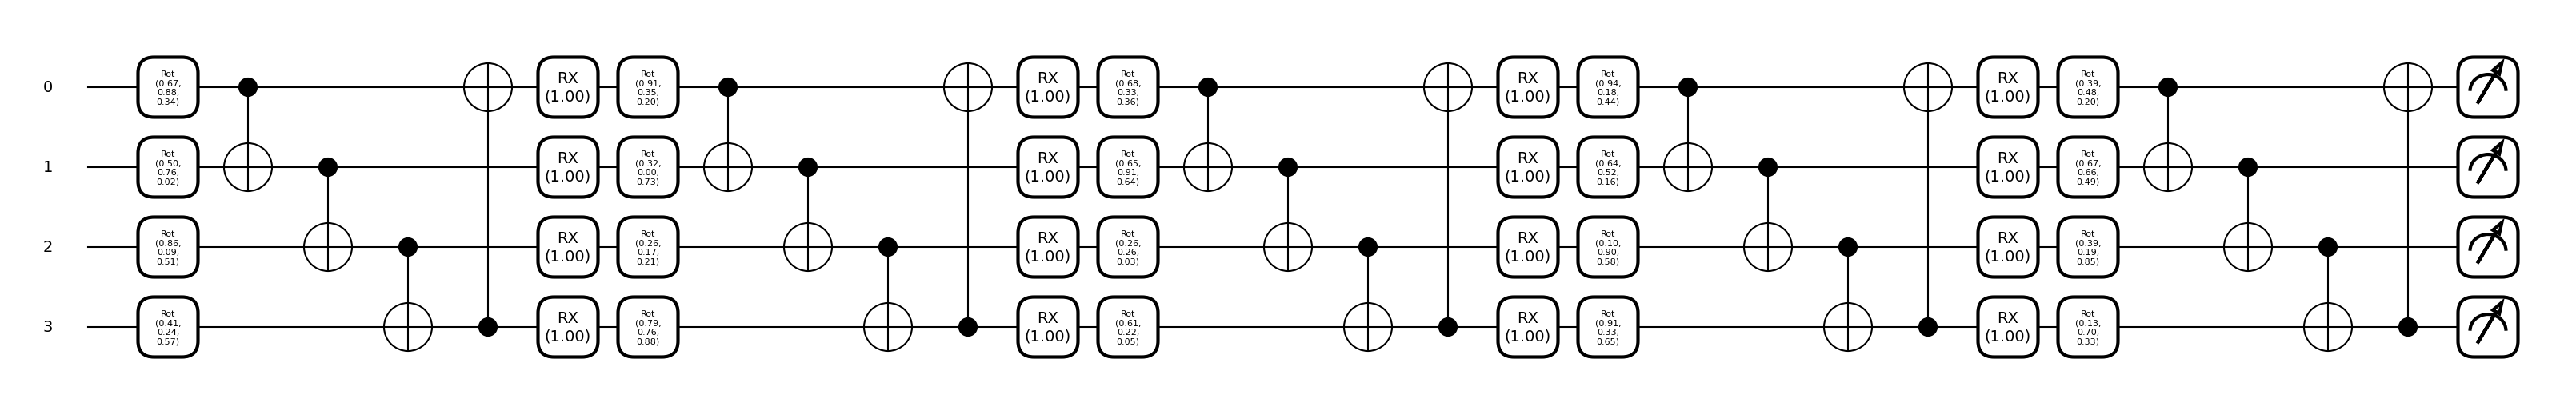

In [6]:
n_qubits = 4
n_depth = 4
n_layers = 1
in_dim = n_qubits * n_depth
out_dim = n_qubits
dev = qml.device("lightning.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def circuit(inputs, w):
    qml.StronglyEntanglingLayers(w[0], wires=range(n_qubits))
    
    for i in range(n_depth):
        qml.AngleEmbedding(features=inputs[i*n_qubits : (i+1)*n_qubits],
                           wires=range(n_qubits),
                           rotation="X")
        qml.StronglyEntanglingLayers(w[i+1], wires=range(n_qubits))
        
    return [qml.expval(qml.PauliZ(k)) for k in range(n_qubits)]

weight_shapes = {"w": (n_depth+1, n_layers, n_qubits, 3)}

qml.draw_mpl(circuit, decimals=2, expansion_strategy='device')(inputs=torch.ones(n_qubits*n_depth, dtype=float),
                                                               w=torch.rand(weight_shapes["w"]))

In [7]:
class FreqNet(nn.Module):
    @deterministic
    def __init__(self, circuit, weight_shapes):
        super().__init__()
        self.qlayer = qml.qnn.TorchLayer(circuit, weight_shapes)
    def forward(self, X):
        X = X.view(-1, 1)
        X = X.expand(-1, in_dim)
        X = self.qlayer(X)
        return X
    
class EncNet(nn.Module):
    @deterministic
    def __init__(self, circuit, weight_shapes):
        super().__init__()
        self.qlayer = qml.qnn.TorchLayer(circuit, weight_shapes)
        self.lin_out = nn.Linear(out_dim, 1)
    def forward(self, X):
        X = X.view(-1, 1)
        X = X.expand(-1, in_dim)

        #for i in range(in_dim):
        #    X[:, i] = X[:, i] * (i+1)
        X = self.qlayer(X)
        X = self.lin_out(X)
        return X

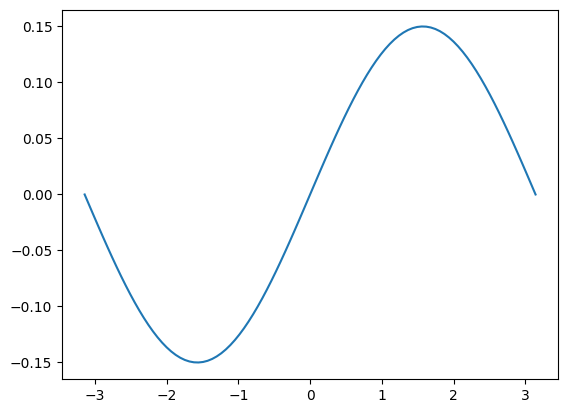

In [8]:
f = lambda x: 0.15 * np.sin(x)
x = np.linspace(-np.pi, np.pi, 100)
plt.plot(x, f(x))

In [10]:
def draw(net):
    y_exact = f(x)
    with torch.no_grad():
        X = torch.tensor(x, dtype=torch.float32)
        y_pred = net(X).numpy()
    
    plt.figure()
    plt.plot(x, y_exact, label="true")
    plt.plot(x, y_pred, label="pred")
    plt.legend()
    plt.show()

def train_adam(net, epochs=100, lr=0.01):
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = nn.MSELoss()
    y_exact = torch.tensor(f(x), dtype=torch.float32)
    
    print("Started Adam training...")
    for e in range(epochs):
        optimizer.zero_grad()
        X = torch.tensor(x, dtype=torch.float32)
        y_pred = net(X).flatten()
        loss = criterion(y_exact, y_pred)
        loss.backward()
        optimizer.step()
    
        print(f"Epoch: {e}\t Loss: {loss.item()}")

def train_lbfgs(net, epochs=10):
    
    def closure():
        optimizer.zero_grad()
        y_pred = net(X).flatten()
        loss = criterion(y_exact, y_pred)
        loss.backward()
        return loss
        
    
    optimizer = torch.optim.LBFGS(net.parameters(), lr=0.1)
    criterion = nn.MSELoss()
    
    print("Started L-BFGS training...")
    for e in range(epochs):
        y_exact = torch.tensor(f(x), dtype=torch.float32)
        X = torch.tensor(x, dtype=torch.float32)
        l = optimizer.step(closure)
        
        print(f"Epoch: {e}\t Loss: {l.item()}")

In [11]:
net = EncNet(circuit, weight_shapes)
train_adam(net, epochs=100)

Started Adam training...
Epoch: 0	 Loss: 0.09144257754087448


KeyboardInterrupt: 

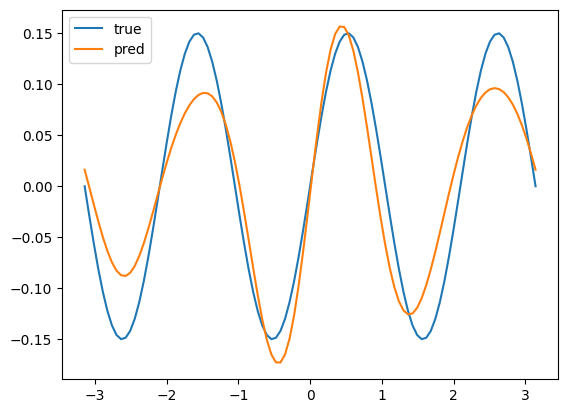

In [9]:
draw(net)

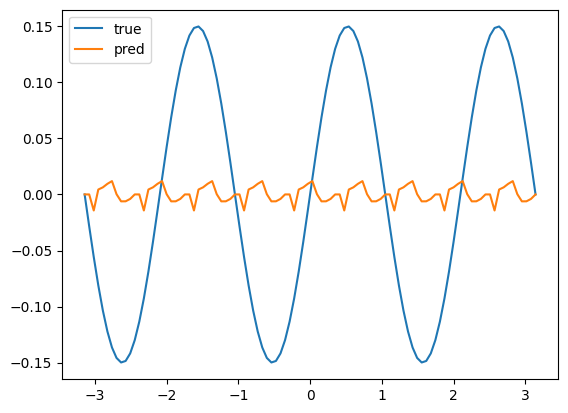

In [25]:
draw(net)

In [28]:
net.lin_out.weight

Parameter containing:
tensor([[0.1618, 0.4192]], requires_grad=True)

In [ ]:
enc_net = EncNet(circuit, weight_shapes)
train_adam(enc_net, epochs=100)

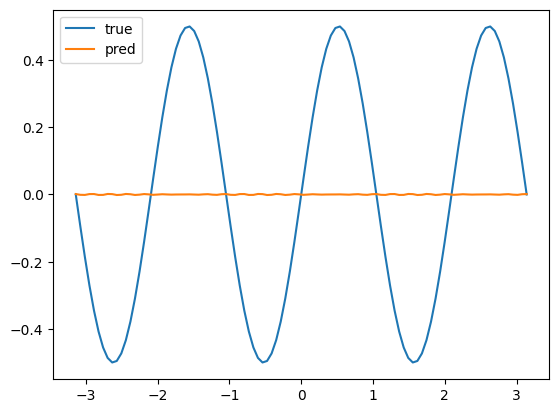

In [36]:
draw(enc_net)

In [22]:
train_lbfgs(net, epochs=50)
torch.save(net.state_dict(), "models/lbfgs")

Started L-BFGS training...


/home/lurker/miniconda3/envs/torch/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([100, 1])) that is different to the input size (torch.Size([100])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0	 Loss: 0.15544253587722778
Epoch: 1	 Loss: 0.13436205685138702
Epoch: 2	 Loss: 0.12385421246290207
Epoch: 3	 Loss: 0.1237514391541481
Epoch: 4	 Loss: 0.12375002354383469
Epoch: 5	 Loss: 0.12375002354383469
Epoch: 6	 Loss: 0.12375002354383469


KeyboardInterrupt: 